In [27]:
import sys, os

project_root = "U:/ML_project/bargh"
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger
from models import Random_Forest, Linear, Polynomial, XGBoost

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

if __name__ == "__main__":
    csv_path = os.path.join(project_root, "data", "processed", "integrated.csv")
    df = pd.read_csv(csv_path, encoding='utf-8')
    logger.info(f"Csv file has bean read successfully")

    feature_adder = Feature_adder(df)
    feature_adder.add_season()
    feature_adder.create_feature_with_delay("temperature", 1)
    feature_adder.create_feature_with_delay("temperature", 2)
    feature_adder.create_feature_with_delay("temperature", 3)
    feature_adder.create_feature_with_delay("generation", 1)
    feature_adder.create_feature_with_delay("generation", 2)
    feature_adder.create_feature_with_delay("generation", 3)
    feature_adder.create_feature_with_delay("generation", 24)

    logger.info(f"Some features have been added successfully")

    data_selector = Data_selector(feature_adder.df)
    df_modified = data_selector.select(m_in_summer=True)
    logger.info(f"Rows have been selected successfully")
    feature_selector = Feature_selector(df_modified, "generation")
    feature_to_be_dropped = ['id', 'date', 'declare', 'require']
    X, y = feature_selector.select(feature_to_be_dropped)
    logger.info(f"Some features have been dropped successfully")



2025-08-18 19:04:20 - model_main - INFO - Csv file has bean read successfully
2025-08-18 19:04:27 - model_main - INFO - Some features have been added successfully
2025-08-18 19:04:27 - model_main - INFO - Rows have been selected successfully
2025-08-18 19:04:28 - model_main - INFO - Some features have been dropped successfully


In [28]:
    import seaborn as sns
    import matplotlib.pyplot as plt
    df_numeric = df_modified.select_dtypes(include=['number'])
    correlation_matrix = df_numeric.corr()

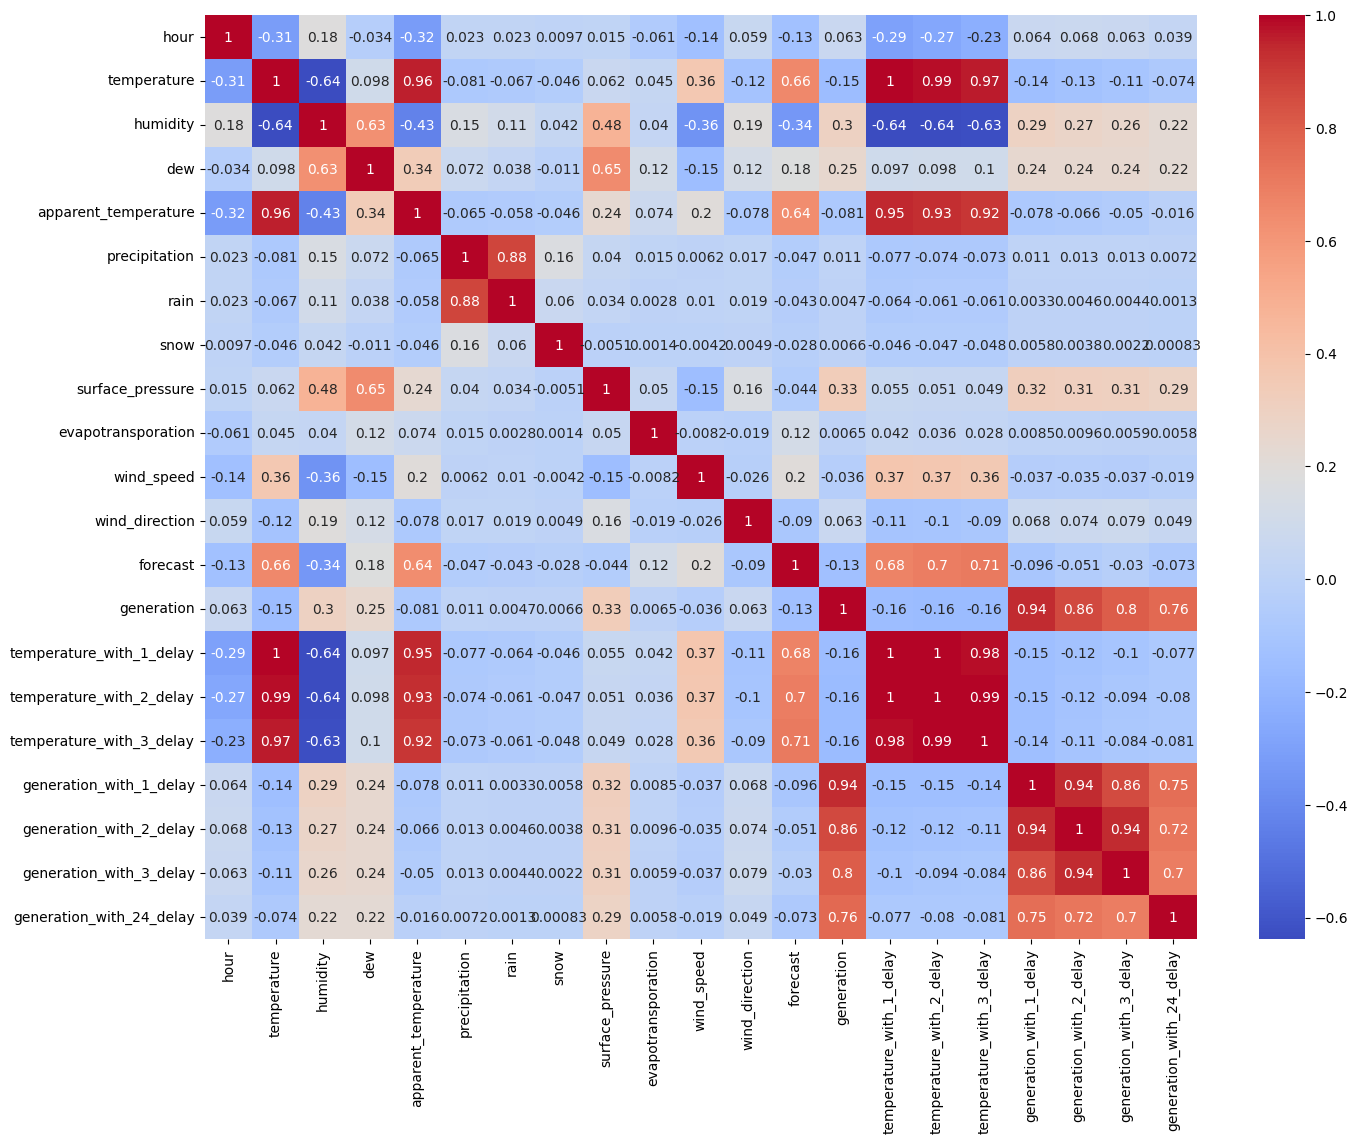

In [29]:
    plt.figure(figsize=(16, 12)) 
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

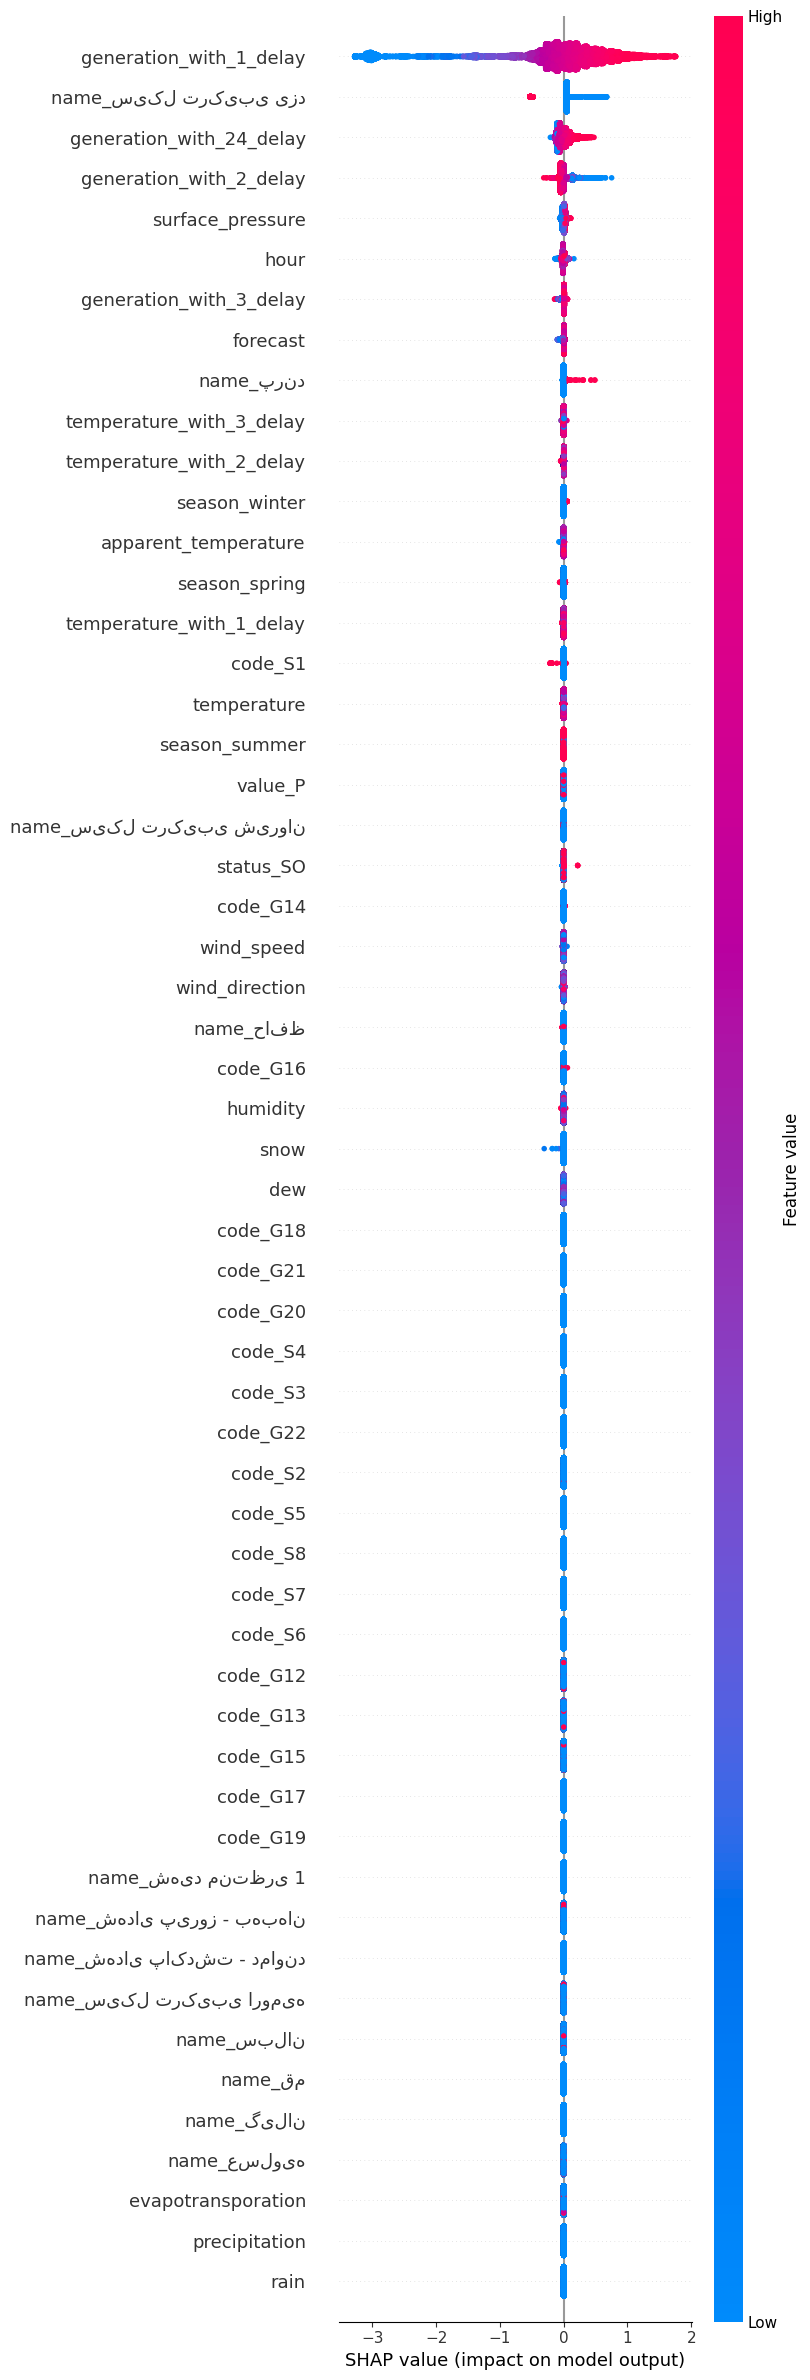

In [30]:
    # Check features importance:
    
    from models import XGBoost
    import xgboost as xgb
    import shap
    
    xgb_model = XGBoost()
    xgb_model.scale_and_split_data(X, y)
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xgb_model.X_train, xgb_model.y_train)
    xgb_model.model = model
    
    
    columns = list(feature_selector.df.columns)
    columns.remove("generation")
    X_test_df  = pd.DataFrame(xgb_model.X_test, columns=columns)
    
    explainer = shap.Explainer(model)

    shap_values = explainer(X_test_df)

    shap.summary_plot(shap_values, X_test_df, max_display=60)
        

In [ ]:
    # This Cell adds model estimate as a column of Data
    model = None
    df2 = pd.read_csv("U:/ML_project/bargh/data/processed/integrated.csv", encoding='utf-8')
    df2.loc[~df2['status'].isin(['SO', 'LF1']), 'status'] = 'SO'
    df2.loc[~df2['value'].isin(['P']), 'value'] = 'P'
    df2.drop(columns=feature_to_be_dropped, axis=1, inplace=True)

    categorical_cols = df2.select_dtypes(include=['object', 'category']).columns
    df2 = pd.get_dummies(df2, columns=categorical_cols, drop_first=True)

    X_all = df2.drop(columns=["generation"])
    y_all = df2["generation"]

    y_pred = model.pred(X_all)
    df3 = pd.read_csv("U:/ML_project/bargh/data/processed/integrated.csv", encoding='utf-8')
    df3['prediction'] = y_pred
    df3.to_csv('U:/ML_project/bargh/data/processed/with_prediction.csv', index=False)